In [1]:
import matplotlib.pyplot as plt
from pickle import dump, load
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import sys
import gurobipy as gb

path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
cd = 0.041
cw = 0.0388

In [2]:
vehicles = pd.read_csv(path+'MOPTA2023_car_locations.csv', sep = ',', header = None)
vehicles = vehicles.append([vehicles]*9,ignore_index=True)

stations = pd.read_csv(path+"fuel_stations.csv")

northern = (-79.761960, 42.269385)
southern = (-76.9909,39.7198)
western = (-80.519400, 40.639400)
eastern = (-74.689603, 41.363559)

stations_loc = stations[["Longitude","Latitude"]]
stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53

stations = stations_loc[(stations_loc["Longitude"] <= 290) & (stations_loc["Latitude"] <= 150)]
stations.rename(columns={"Longitude": 0, "Latitude":1}, inplace=True)

stations.index = np.arange(1, len(stations) + 1)
vehicles.index = np.arange(1, len(vehicles) + 1)

C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_7800\1565693129.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vehicles = vehicles.append([vehicles]*9,ignore_index=True)
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_7800\1565693129.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_7800\1565693129.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [ ]:
def generate_distances():
    distances = dict()
    for i in vehicles.index:
        for st in stations.index:    
            distances[i,st] = euclidean([vehicles[0][i], vehicles[1][i]],[stations[0][st], stations[1][st]])
    return distances


In [ ]:
d = generate_distances()

In [ ]:
file = open(path + f'feasible instances', 'rb')
data = load(file)
file.close()

p = {}
for sc in range(25):
    r = data[ data[f"realized {sc}"] == True ]
    r = dict(r.loc[:,[f"ranges {sc}"]].squeeze())
    
    p[sc] = {(k,s):250-(r[k]-d[k,s]) for s in stations.index for k in K_s[sc][s]}
    file = open(path + f'/p/p_{sc}', 'wb')
    dump(p[sc], file)
    file.close()


In [ ]:
cdw = {}
for sc in range(25):
    cdw[sc] = {}
    for st in stations.index:
        if len(K_s[sc][st]) > 0:
            cdw[sc][st] = sum(cd*d[k,st]+cw*p[sc][k,st] for k in K_s[sc][st])/len(K_s[sc][st])
        else:
            cdw[sc][st] = 250*(cd+cw)

In [ ]:
for sc in range(25):
    file = open(path+f"b/b_sc{sc}", "wb")
    dump(b[sc],file); file.close()

    file = open(path+f"cdw/cdw_sc{sc}", "wb")
    dump(cdw[sc],file); file.close()


In [ ]:
c_s = {s:sum(cdw[sc][s] for sc in range(25))/25 for s in S}
file = open(path+"c_s","wb")
dump(c_s,file); file.close()

# Model

In [28]:
file = open(path+"S", "rb"); S = load(file); file.close()
file = open(path+"c_s", "rb"); c_s = load(file); file.close()

K = {}; S_k = {}; K_s = {}
for sc in range(25):
    file = open(path+f"K/K_sc{sc}", "rb")
    K[sc] = load(file); file.close()

    file = open(path+f"S_k/Sk_sc{sc}", "rb")
    S_k[sc] = load(file); file.close()    

    file = open(path+f"K_s/Ks_sc{sc}", "rb")
    K_s[sc] = load(file); file.close()

In [29]:
m = gb.Model("First Stage")

theta = {s:m.addVar(name=f"theta_{s}",vtype=gb.GRB.BINARY) for s in S}
zz = m.addVar(name="z",vtype=gb.GRB.CONTINUOUS)

m.addConstr(gb.quicksum(theta[s] for s in S) == 600)

for sc in range(25):
    for k in K[sc]:
        m.addConstr(gb.quicksum(theta[s] for s in S_k[sc][k]) >= 1)
    for s in S:
        m.addConstr(zz >= theta[s]*len(K_s[sc][s]))

#m.setObjective(gb.quicksum(c_s[s]*theta[s] for s in S))
m.setObjective(zz)

m.update()
#m.setParam("OutputFlag",0)
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1265U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 143596 rows, 1213 columns and 1188986 nonzeros
Model fingerprint: 0xc5f5765d
Variable types: 1 continuous, 1212 integer (1212 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Found heuristic solution: objective 447.0000000
Presolve removed 142628 rows and 466 columns
Presolve time: 1.25s
Presolved: 968 rows, 747 columns, 7959 nonzeros
Variable types: 0 continuous, 747 integer (630 binary)

Root relaxation: objective 1.080658e+02, 348 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

# Open Stations Plotting

In [30]:
open_stations = [s for s in S if theta[s].X>0.5]

[]

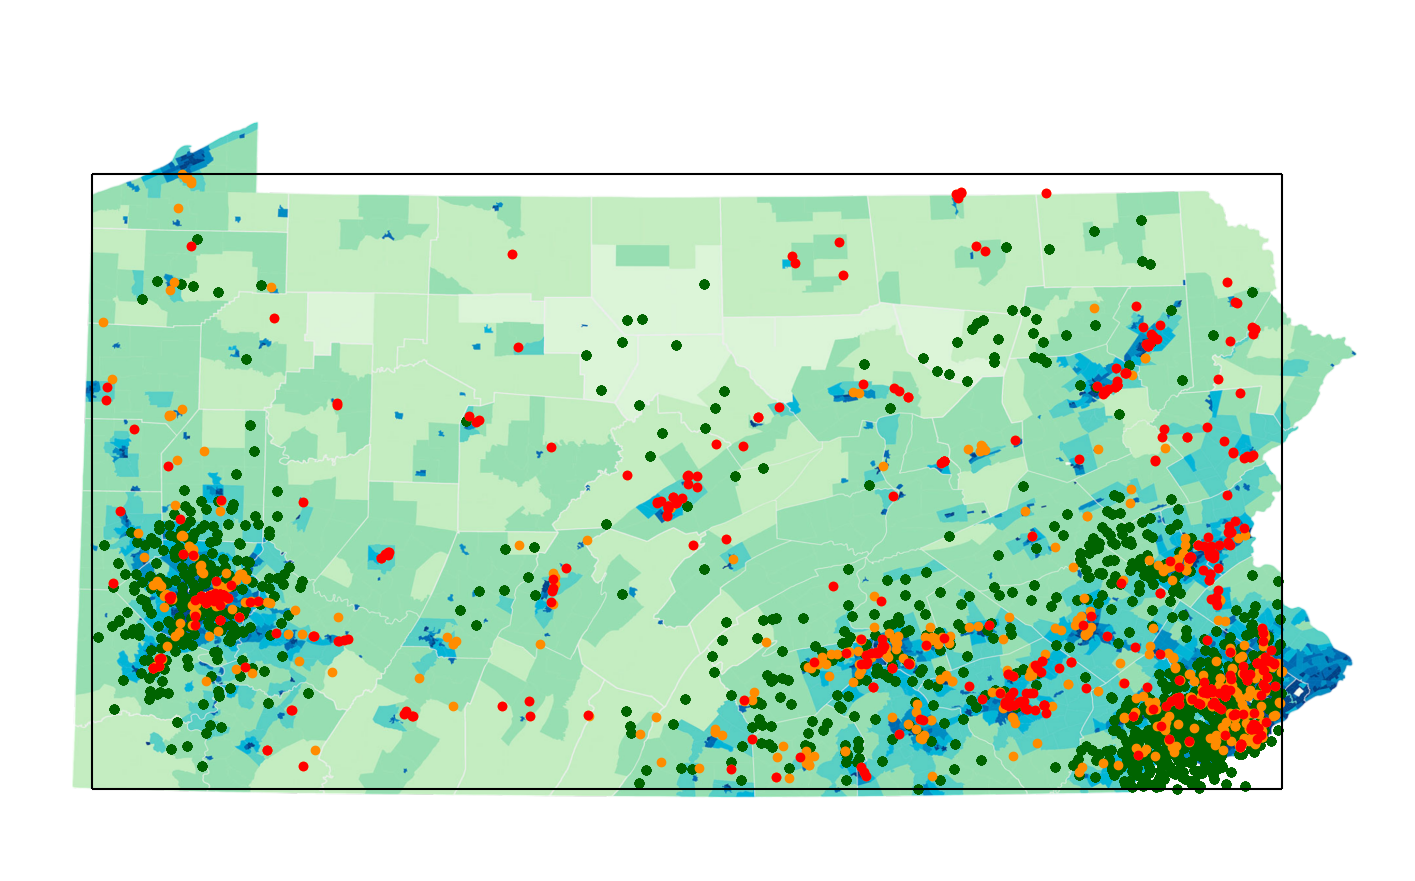

In [31]:
img = plt.imread("./Problem Visualization/Pennsylvania_Population.png")
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))


for v in vehicles.index:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="darkgreen")

oor = 0
for v in stations.index:
        x_v = stations.loc[v,0]; y_v = stations.loc[v,1]
        if x_v > 290 or y_v > 150: col= "magenta"; oor += 1
        else: col = "darkorange"
        ax.plot(x_v,y_v,marker="o",color=col)

for s in open_stations:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="red")

ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

ax.spines[["top","bottom","left","right"]].set_visible(False)

#ax.imshow(img, extent=[-5, 308, -5, 178])
ax.imshow(img, extent=[-5, 308, -5, 165])
#ax.legend(loc="upper right")
ax.set_xlim(-20,320)
ax.set_ylim(-20,190)
ax.set_xticks([]); ax.set_yticks([])

#plt.savefig("./Problem Visualization/Vehicles+Stations map",dpi=300,transparent=True)

In [7]:
del vehicles
del stations
del stations_loc

# Feasibility check

In [32]:
from source import *

In [33]:
objs = {}
sc = 0
print(f"Running for scenario {sc}")
y = {s:8 for s in open_stations}

K, K_s, S_k, a, t = load_pickle(path,sc)
S_k = {k:[s for s in S_k[k] if s in open_stations] for k in K}
a.update({("s",s):0 for s in open_stations})
a.update({("e",s):10 for s in open_stations})
t.update({("e",s):0 for s in open_stations})

objs[sc] = second_stage_ESPP(open_stations,K,K_s,S_k,2,y,a,t)
print(f"Final result for scenario {sc}: {objs[sc]} infeasible vehicles\n")

Running for scenario 0
Iteration 0:	4590 infeasible vehicles	MP obj: 4590.0	time: 0.03s
Iteration 1:	3818 infeasible vehicles	MP obj: 3818.0	time: 31.02s
Iteration 2:	2873 infeasible vehicles	MP obj: 2872.0	time: 69.62s
Iteration 3:	2184 infeasible vehicles	MP obj: 2184.0	time: 96.34s
Iteration 4:	1865 infeasible vehicles	MP obj: 1856.0	time: 111.95s
Iteration 5:	1787 infeasible vehicles	MP obj: 1780.0	time: 119.61s
Iteration 6:	1770 infeasible vehicles	MP obj: 1760.0	time: 122.81s
Iteration 7:	1765 infeasible vehicles	MP obj: 1754.0	time: 125.08s
Iteration 8:	1762 infeasible vehicles	MP obj: 1751.0	time: 127.41s
Final result for scenario 0: (1751.0, [8192, 8198, 8202, 8205, 8212, 8214, 8215, 8219, 8224, 8225, 8234, 8236, 46, 8238, 8242, 8246, 8249, 8251, 8254, 8263, 8266, 78, 8269, 8274, 8277, 8281, 8289, 100, 8291, 8321, 8322, 8328, 8331, 138, 8334, 145, 146, 155, 8350, 8354, 8359, 8360, 8375, 8385, 8399, 8404, 8405, 214, 8411, 8412, 8415, 8421, 8422, 8425, 8431, 8440, 8445, 8446, 84

In [34]:
vehicles = pd.read_csv(path+'MOPTA2023_car_locations.csv', sep = ',', header = None)
vehicles = vehicles.append([vehicles]*9,ignore_index=True)

stations = pd.read_csv(path+"fuel_stations.csv")

northern = (-79.761960, 42.269385)
southern = (-76.9909,39.7198)
western = (-80.519400, 40.639400)
eastern = (-74.689603, 41.363559)

stations_loc = stations[["Longitude","Latitude"]]
stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
stations_loc["Longitude"] = (stations["Longitude"]-western[0])*53

stations = stations_loc[(stations_loc["Longitude"] <= 290) & (stations_loc["Latitude"] <= 150)]
stations.rename(columns={"Longitude": 0, "Latitude":1}, inplace=True)

stations.index = np.arange(1, len(stations) + 1)
vehicles.index = np.arange(1, len(vehicles) + 1)


C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_7800\107480968.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vehicles = vehicles.append([vehicles]*9,ignore_index=True)
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_7800\107480968.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_loc["Latitude"] = (stations["Latitude"]-southern[1])*69*165/178
C:\Users\a.rojasa55\AppData\Local\Temp\ipykernel_7800\107480968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

[]

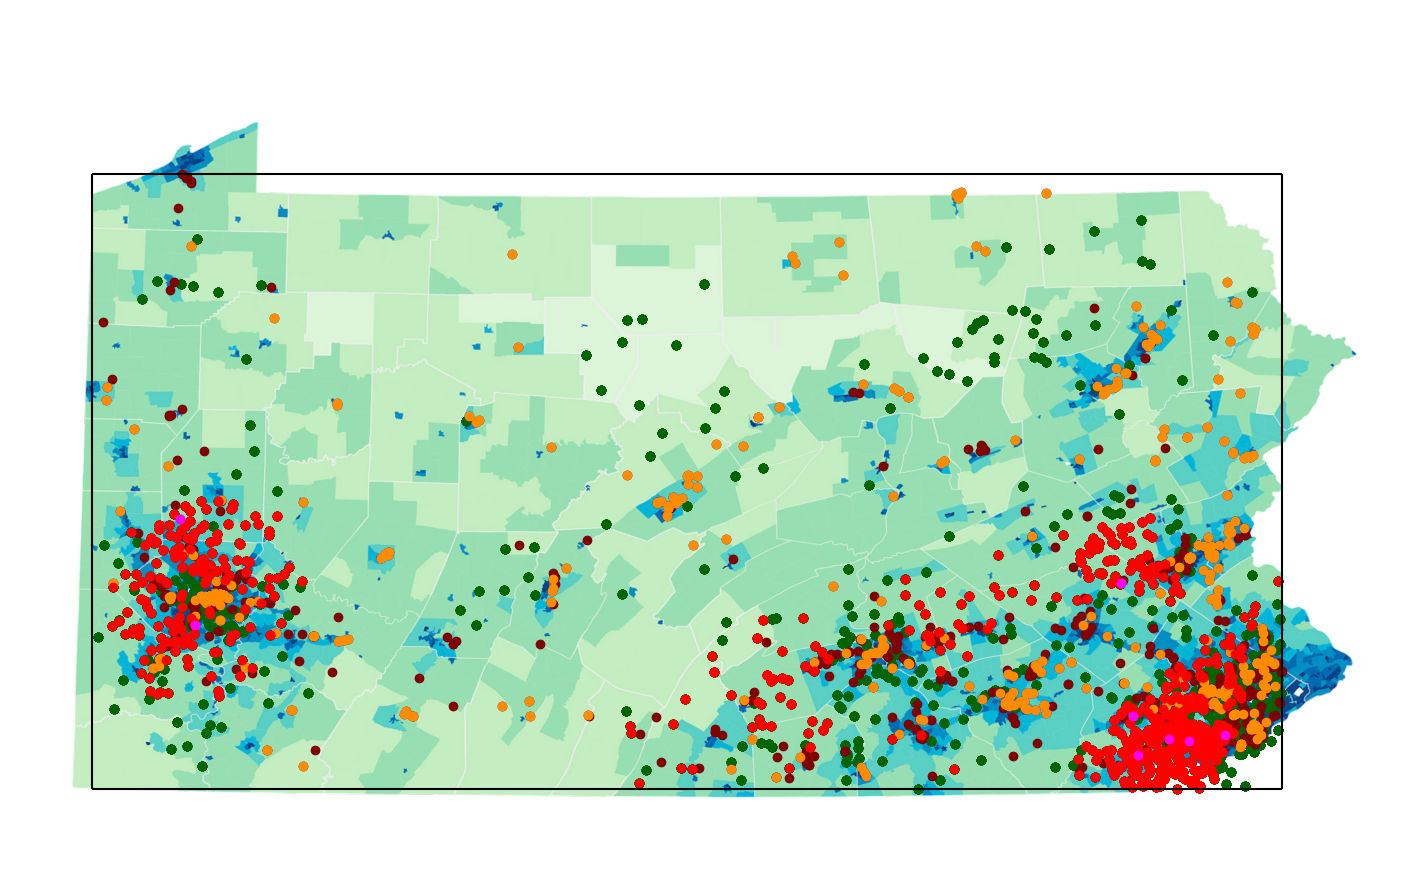

In [35]:
img = plt.imread("./Problem Visualization/Pennsylvania_Population.png")
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

for v in vehicles.index:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="darkgreen")

for s in stations.index:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="maroon")

for s in open_stations:
        x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
        ax.plot(x_v,y_v,marker="o",color="darkorange")

for v in objs[0][1]:
        x_v = vehicles.loc[v,0]; y_v = vehicles.loc[v,1]
        ax.plot(x_v,y_v,marker="o",color="red")

for s in open_stations:
        if len(K_s[s]) > 100:
                x_v = stations.loc[s,0]; y_v = stations.loc[s,1]
                ax.plot(x_v,y_v,marker="o",color="magenta")

ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

ax.spines[["top","bottom","left","right"]].set_visible(False)

#ax.imshow(img, extent=[-5, 308, -5, 178])
ax.imshow(img, extent=[-5, 308, -5, 165])
#ax.legend(loc="upper right")
ax.set_xlim(-20,320)
ax.set_ylim(-20,190)
ax.set_xticks([]); ax.set_yticks([])

77 open stations have more than 100 possible vehicles to be assigned


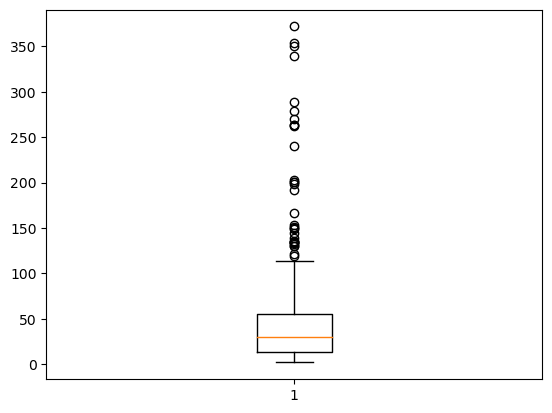

In [19]:
plt.boxplot([len(K_s[s]) for s in open_stations])
print(f"{sum(1 if len(K_s[s]) > 100 else 0 for s in S)} open stations have more than 100 possible vehicles to be assigned")

In [21]:
min([len(K_s[s]) for s in open_stations])

2